# Полиномиальная модель

## Проблема

Данные не всегда могут быть **хорошо разделены (гипер)плоскостью**. Например, рассмотрим следующее: у нас есть данные по дозировке лекарства и 2 класса — пациенты, которые поправились, и те, которым лучше не стало.

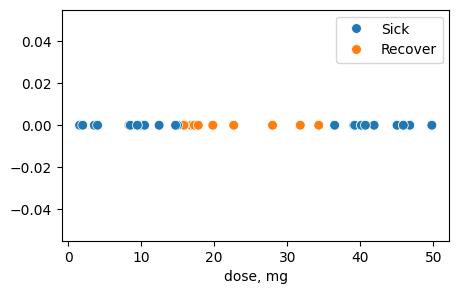

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


def generate_patients_data(total_len=40):
    x = np.random.uniform(0, 50, total_len)
    y = np.zeros_like(x)
    y[(x > 15) & (x < 35)] = 1
    return x, y


def plot_data(x, y, total_len=40, s=50):
    plt.figure(figsize=(5, 3))
    ax = sns.scatterplot(x=x, y=np.zeros(len(x)), hue=y, s=s)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Sick", "Recover"])
    ax.set(xlabel="dose, mg")
    return ax


total_len = 40
x, y = generate_patients_data(total_len=total_len)
ax = plot_data(x, y, total_len=total_len)
plt.show()

Соответственно, мы не можем найти такое пороговое значение, которое будет разделять наши классы на больных и здоровых, и, следовательно, и использовать линейную модель.  

Преобразуем наши данные таким образом, чтобы они стали 2-хмерными. В качестве значений по оси Y будем использовать дозу, возведенную в квадрат (**доза**$^2$).

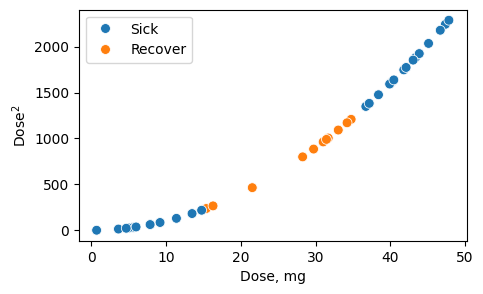

In [10]:
def plot_data(x, y, total_len=40, s=50):
    plt.figure(figsize=(5, 3))
    ax = sns.scatterplot(x=x[0, :], y=x[1, :], hue=y, s=s)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Sick", "Recover"])
    ax.set(xlabel="Dose, mg")
    ax.set(ylabel="Dose$^2$")
    return ax


total_len = 40
x_1, y = generate_patients_data(total_len=total_len)
x_2 = x_1**2
x = np.vstack([x_1, x_2])

plot_data(x, y, total_len=40, s=50)
plt.show()

Теперь можно найти прямую которая разделит данные

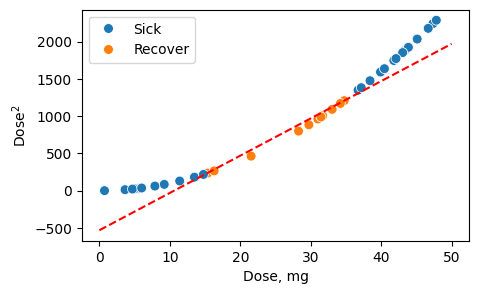

In [11]:
plot_data(x, y, total_len=40, s=50)

x_arr = np.linspace(0, 50, 50)
xs = [x[0, :][y == 1].min(), x[0, :][y == 1].max()]
ys = [x[1, :][y == 1].min(), x[1, :][y == 1].max()]

# Calculate the coefficients.
coefficients = np.polyfit(xs, ys, 1)

# Let's compute the values of the line...
polynomial = np.poly1d(coefficients)
y_axis = polynomial(x_arr)

# ...and plot the points and the line
plt.plot(x_arr, y_axis, "r--")
plt.show()

## Пример использования

In [17]:
import sklearn
from sklearn.datasets import load_wine

# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine

# Download dataset
features, class_labels = load_wine(
    return_X_y=True, as_frame=True
)  # also we can get data in Bunch (dictionary) or pandas DataFrame

wine_dataset = features
wine_dataset["target"] = class_labels

from sklearn.model_selection import train_test_split

# Split the data into train and test data
x_train, x_test, y_train, y_test = train_test_split(
    features.values, class_labels.values, test_size=0.25, random_state=42
)

wine_dataset.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [12]:
from sklearn.preprocessing import PolynomialFeatures
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

pf = PolynomialFeatures(degree=2)
new_features_train = pf.fit_transform(x_train)
new_features_test = pf.fit_transform(x_test)

print("Old features count ",x_train.shape[1],"new features count", new_features_train.shape[1])

Old features count  14 new features count 120


In [13]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


sgd = SGDClassifier(loss = "hinge", max_iter=1000,random_state = 42)
scaler = StandardScaler().fit(new_features_train)
x_train_scaled = scaler.transform(new_features_train)
sgd.fit(x_train_scaled,y_train)

# Calculate F1_score
x_test_scaled = scaler.transform(new_features_test)
pred = sgd.predict(x_test_scaled)
print("F1 score", f1_score(y_test, pred, average="macro"))

F1 score 1.0


## Переобучение

Сложность модели связана с **ошибкой обобщения** (_generalization error_):
- **Cлишком простой модели** не будет хватать **количества параметров для обобщения сложной закономерности в данных**, что приведёт к большой ошибке обобщения.
- **Избыточная сложность модели** также приводит к большой ошибке обобщения за счет того, что в силу своей сложности модель начинает **пытаться искать закономерности в шуме**, добиваясь большей точности на тренировочных данных, теряя при этом часть обобщающей способности.

<img src ="https://ml.gan4x4.ru/msu/dev-2.0/L02/out/model_complexity.png" width="500">



__Сложность модели__ (*model complexity*) — важный гиперпараметр. В частности, для линейных моделей сложность может быть представлена **количеством параметров**, например, для полиномиальных моделей — степенью полинома.

Параметры модели задают некоторую **аппроксимацию целевой функции**. Аппроксимировать целевую функцию можно несколькими способами, например:
1. Использовать все имеющиеся данные и провести ее строго **через все точки**, которые нам известны ($f1$ на картинке);
2. Использовать более простую функцию (в данном случае, линейную), которая не попадет точно во все данные, но зато будет соответствовать некоторым **общим закономерностям**, которые у них есть ($f2$ на картинке).

Характерной чертой переобучения является первый сценарий, и сопровождается он, как правило, **большими весами**. Поэтому регуляризацию используют для борьбы с переобучением.

<img src ="https://ml.gan4x4.ru/msu/dev-2.0/L02/out/l2_regularization.png" width="300">

Проиллюстрируем описанное явление на примере полиномиальной модели:

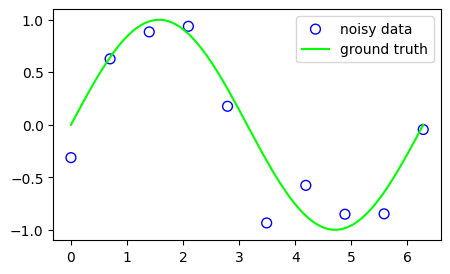

In [14]:
x = np.linspace(0, 2 * np.pi, 10)
y = np.sin(x) + np.random.normal(scale=0.25, size=len(x))
x_true = np.linspace(0, 2 * np.pi, 200)
y_true = np.sin(x_true)

plt.figure(figsize=(5, 3))
plt.scatter(x, y, s=50, facecolors="none", edgecolors="b", label="noisy data")
plt.plot(x_true, y_true, c="lime", label="ground truth")
plt.legend()
plt.show()

Попробуем аппроксимировать имеющуюся зависимость с помощью полиномиальной модели, используя шумные данные в качестве тренировочных данных:

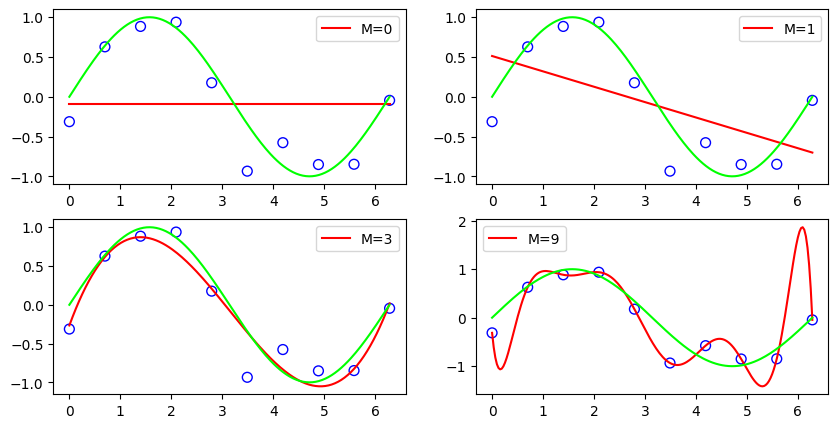

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

x_train = x.reshape(-1, 1)

fig = plt.figure(figsize=(10, 5))

for i, degree in enumerate([0, 1, 3, 9]):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    model.fit(x_train, y)
    y_plot = model.predict(x_true.reshape(-1, 1))

    fig.add_subplot(2, 2, i + 1)
    plt.plot(x_true, y_plot, c="red", label=f"M={degree}")
    plt.scatter(x, y, s=50, facecolors="none", edgecolors="b")
    plt.plot(x_true, y_true, c="lime")
    plt.legend()
plt.show()

Модель **переобучается, подстраиваясь под тренировочную выборку**. В полиноме степень/количество весов — это гиперпараметр, который можно подбирать на кросс-валидации, но **ограничивая колличество параметров**, мы накладываем **ограничение на обобщающую способность модели** в целом. Вместо этого можно оставить модель сложной, но использовать **регуляризатор**, который будет заставлять модель отдавать предпочтение более простому обобщению.

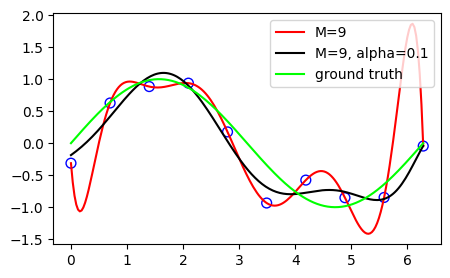

Without regularization:  y = 0.0+-10.87*x+49.52*x^2+-78.32*x^3+63.62*x^4+-29.7*x^5+8.25*x^6+-1.34*x^7+0.12*x^8+-0.0*x^9
With regularization:  y = 0.0+0.63*x+0.3*x^2+0.16*x^3+-0.04*x^4+-0.27*x^5+0.17*x^6+-0.04*x^7+0.0*x^8+-0.0*x^9


In [16]:
from sklearn.linear_model import Ridge
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

model = make_pipeline(PolynomialFeatures(9), LinearRegression())
model_ridge = make_pipeline(PolynomialFeatures(9), Ridge(alpha=0.1))

model.fit(x_train, y)
y_plot = model.predict(x_true.reshape(-1, 1))

model_ridge.fit(x_train, y)
y_plot_ridge = model_ridge.predict(x_true.reshape(-1, 1))

plt.figure(figsize=(5, 3))
plt.plot(x_true, y_plot, c="red", label=f"M={degree}")
plt.plot(x_true, y_plot_ridge, c="black", label=f"M={degree}, alpha=0.1")
plt.scatter(x, y, s=50, facecolors="none", edgecolors="b")
plt.plot(x_true, y_true, c="lime", label="ground truth")
plt.legend()
plt.show()

poly_coef = model[1].coef_

eq = f"y = {round(poly_coef[0], 2)}+{round(poly_coef[1], 2)}*x"
for i in range(2, 10):
    eq += f"+{round(poly_coef[i], 2)}*x^{i}"

print("Without regularization: ", eq)

poly_coef = model_ridge[1].coef_

eq = f"y = {round(poly_coef[0], 2)}+{round(poly_coef[1], 2)}*x"
for i in range(2, 10):
    eq += f"+{round(poly_coef[i], 2)}*x^{i}"

print("With regularization: ", eq)

Видно, что одним из "симптомов" переобучения являются аномально большие веса. Модель Ridge Regression, показанная в примере выше, использует L2-регуляризацию для борьбы с этим явлением.
